# Comparison

In [10]:
#!pip install vendi_score

  Using cached vendi_score-0.0.3-py3-none-any.whl
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [1]:
from sklearn.metrics import pairwise_distances
from datasets import load_dataset
import numpy as np

flores_lan = "eng_Latn"
lan = flores_lan.split("_")[0]
ds = load_dataset("facebook/flores", "eng_Latn")

In [ ]:
%cd experiments/ICL-MT

In [3]:
dico = {}
for method in [
    "Cohere",
    "Laser2",
    "LaBSE",
    "E5",
    "SONAR",
    "BLOOM_one",
    "BLOOM_middle",
    "BLOOM_last",
    "BLOOM_one_avg",
    "BLOOM_middle_avg",
    "BLOOM_last_avg"
] :
    if method == "Cohere" :
        X = np.fromfile(f"./data/flores/{lan}/{method}/devtest.bin")
        Y = np.fromfile(f"./data/flores/{lan}/{method}/dev.bin")
    else :
        X = np.fromfile(
            f"../data/flores/{lan}/{method}/devtest.bin",
            dtype=np.float32,
            count=-1
        )
        Y = np.fromfile(
            f"../data/flores/{lan}/{method}/dev.bin",
            dtype=np.float32,
            count=-1
        )
    X = X.reshape(len(ds["devtest"]), -1)
    Y = Y.reshape(len(ds["dev"]), -1)
    D = pairwise_distances(X, Y, metric="cosine")

    print(
        np.argsort(D, axis=-1)[0, 0:3]
    )
    dico[method] = D

[170 143 198]
[508 238 777]
[170 271 238]
[170 143 272]
[170 272 342]
[272  61 238]
[ 56 272 199]
[144 238 272]
[162  61 170]
[272 834 741]
[984 523 197]


In [4]:
def compare(D1, D2, k=1, with_order=False):
    assert D1.shape[0] == D2.shape[0]
    K1, K2 = np.argsort(D1, axis=-1)[:, :k], np.argsort(D2, axis=-1)[:, :k]
    L = []
    for i in range(K1.shape[0]):
        L1 = K1[i].tolist()
        L2 = K2[i].tolist()
        if not with_order :
            L.append(
                sum(
                    [(v in L1) for v in L2]
                )
                #len(list(set(L1) & set(L2)))
            )
        else :
            L.append(
                sum([(a==b) for a, b in zip(L1, L2)])
            )
    return L

In [5]:
import pandas as pd
k=10
df = pd.DataFrame.from_dict(
    {
        k2 : [
            round(
                np.mean(
                    compare(v2, v1, k)
                ),
                2
            )
            for k1, v1 in dico.items()
        ] 
        for k2, v2 in dico.items()
    },
    orient = "index",
    columns = list(dico.keys())
)

In [6]:
METHODS = ["Cohere", "E5", "LaBSE", "Laser2", "SONAR"]
df.loc[METHODS, METHODS]

,Cohere,E5,LaBSE,Laser2,SONAR
Cohere,10.00,5.87,2.68,1.29,2.96
E5,5.87,10.00,2.64,1.38,2.77
LaBSE,2.68,2.64,10.00,2.21,2.95
Laser2,1.29,1.38,2.21,10.00,2.13
SONAR,2.96,2.77,2.95,2.13,10.00


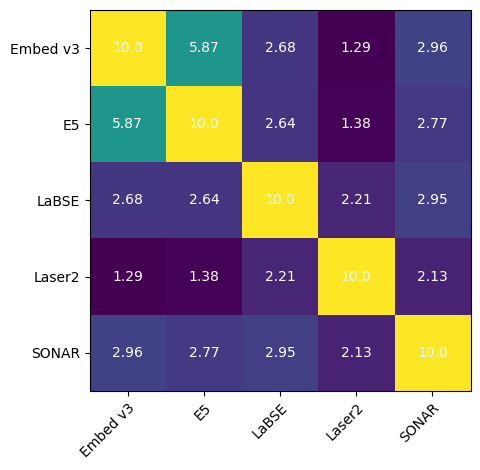

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
matrix = df.loc[METHODS, METHODS].values
im = ax.imshow(
    matrix, 
    #map="Purples"
    #cmap="Blues"
    #cmap="plasma"
)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(METHODS)), labels= ["Embed v3"] + METHODS[1:])
ax.set_yticks(np.arange(len(METHODS)), labels= ["Embed v3"] + METHODS[1:])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(METHODS)):
    for j in range(len(METHODS)):
        text = ax.text(j, i, matrix[i, j],
                       ha="center", va="center", color="w")

#ax.set_title("Average number of in-context examples in common in 10-shot.")
fig.tight_layout()
# plt.savefig("intersection.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [8]:
def get(D, i, k):
    K = np.argsort(D, axis=-1)[i, :k].tolist()
    print(ds["devtest"][i]["sentence"])
    print('-'*50)
    for j in K:
        print(f"{j}: {ds['dev'][j]['sentence']}")
        print('-'*50)

In [9]:
get(dico["LaBSE"], 2, 3)

Like some other experts, he is skeptical about whether diabetes can be cured, noting that these findings have no relevance to people who already have Type 1 diabetes.
--------------------------------------------------
372: Other scientists argue that these plants are very poisonous so it is unlikely that any dinosaur ate them, even though today the sloth and other animals like the parrot (a descendant of the dinosaurs) can eat poisonous leaves or fruit.
--------------------------------------------------
272: Some studies suggest that the disease must become less lethal before it can cause a global epidemic, he noted.
--------------------------------------------------
271: Dr. Lee also expressed his concern about reports that children in Turkey have now become infected with the A(H5N1) avian influenza virus without becoming ill.
--------------------------------------------------


In [10]:
get(dico["Laser2"], 2, 3)

Like some other experts, he is skeptical about whether diabetes can be cured, noting that these findings have no relevance to people who already have Type 1 diabetes.
--------------------------------------------------
183: The Health Minister expressed concern both for the welfare of individuals taking advantage of the temporary legality of the substances involved, and for drug-related convictions handed down since the now-unconstitutional changes came into effect.
--------------------------------------------------
372: Other scientists argue that these plants are very poisonous so it is unlikely that any dinosaur ate them, even though today the sloth and other animals like the parrot (a descendant of the dinosaurs) can eat poisonous leaves or fruit.
--------------------------------------------------
75: Roberts flatly refused to say about when he believes life begins, an important question when considering the ethics of abortion, saying that it would be unethical to comment on the spe

# SONAR vs BM25

In [12]:
ds_src = load_dataset("facebook/flores", "eng_Latn")

In [13]:
from rank_bm25 import BM25Okapi

devtest = [ex["sentence"] for ex in ds_src["devtest"]]
dev = [ex["sentence"] for ex in ds["dev"]]

tokenized_dev = [doc.split(" ") for doc in dev]
bm25 = BM25Okapi(tokenized_dev)

def f(example):
    return bm25.get_scores(example.split(" "))

import multiprocess as mp

p = mp.Pool(8)

bm25_scores = p.map(f, devtest)
D_bm25 = np.array([score for score in bm25_scores]).reshape(len(devtest), len(dev))

In [14]:
D_bm25.argsort(axis=-1)[0, -10:]

array([ 68, 153,  61, 921, 103, 182, 633, 271, 777, 314])

In [15]:
sum(compare(dico["SONAR"], D_bm25, k=1))/10

0.1

In [16]:
D1 = dico["SONAR"]
D2 = D_bm25

i = 127

k = 10
R1 = D1[i].argsort()[-k:]
R2 = D2[i].argsort()[-k:]
intersection = list(set(R1) & set(R2))

print(f"Intersection : {intersection}")
# Give an advantage to those who are in both
fusion = {}
for element in intersection :
    fusion[element] = 1
for j in range(k):
    if R2[j] in fusion :
        fusion[R2[j]] += j
    else :
        fusion[R2[j]] = j

for j in range(k):
    if R1[j] in fusion :
        fusion[R1[j]] += j
    else :
        fusion[R1[j]] = j
    

L = [(key, v) for (key, v) in fusion.items()]
L = [(key, v, j) for j, (key, v) in enumerate(L)]
print(L)
L = sorted(L, key = lambda x : (x[1], x[2]))

fusion = [alpha for (alpha, _, _) in L][-k:]
print(f"Left : {R1}\nRight: {R2}\nMerge: {fusion}")

Intersection : []
[(430, 0, 0), (439, 1, 1), (129, 2, 2), (104, 3, 3), (979, 4, 4), (403, 5, 5), (637, 6, 6), (866, 7, 7), (160, 8, 8), (863, 9, 9), (746, 0, 10), (239, 1, 11), (303, 2, 12), (212, 3, 13), (380, 4, 14), (176, 5, 15), (328, 6, 16), (307, 7, 17), (3, 8, 18), (234, 9, 19)]
Left : [746 239 303 212 380 176 328 307   3 234]
Right: [430 439 129 104 979 403 637 866 160 863]
Merge: [403, 176, 637, 328, 866, 307, 160, 3, 863, 234]


# R-BM25

In [17]:
from datasets import load_dataset
ds_src = load_dataset("facebook/flores", "eng_Latn")

In [18]:
from sacremoses import MosesTokenizer, MosesDetokenizer
from rank_bm25 import BM25Okapi
import numpy as np
import os

mt_tok = MosesTokenizer(lang="en")
devtest = [ex["sentence"] for ex in ds_src["devtest"]]
dev = [ex["sentence"] for ex in ds_src["dev"]]

tokenized_dev = [mt_tok.tokenize(doc) for doc in dev]
bm25 = BM25Okapi(tokenized_dev)

def f(example):
    return bm25.get_scores(mt_tok.tokenize(example))

import multiprocess as mp

p = mp.Pool(8)

bm25_scores = p.map(f, devtest)
D_bm25 = np.array([score for score in bm25_scores]).reshape(len(devtest), len(dev))

In [ ]:
from create_recall_set_selection import select_prompt_set

weight = 0.1 # lambda
ignore_whitespace = False
min_bleu_threshold = 0.01 # threshold
k = 10
def g(i):
    source = devtest[i]
    top_n_indices = np.argsort(D_bm25[i])[-100:]
    prompt_src = [dev[int(idx)] for idx in top_n_indices]
    selected_indices = select_prompt_set(
        source, 
        prompt_src,
        weight=weight,
        ignore_whitespace=ignore_whitespace,
        min_bleu_threshold=min_bleu_threshold
    )
    #print(f"len prompt src = {len(prompt_src)}")
    #print(f"len = {len(selected_indices)}")
    return selected_indices #[prompt_src[j] for j in selected_indices]

In [ ]:
p = mp.Pool(8)
R = p.map(g, [i for i in range(len(devtest))])

In [ ]:
print(max([len(element) for element in R]))
print(min([len(element) for element in R]))

82
12


# POOL

In [3]:
from datasets import load_dataset
import numpy as np
flores_lan = "eng_Latn"
lan = flores_lan.split("_")[0]
ds = load_dataset("facebook/flores", "eng_Latn")

In [4]:
from sklearn.metrics import pairwise_distances
method = "SONAR"
#pool_name = "pool_nllb_en_to_fr"
pool_name = "pool_nllb_en_to_sw"
X = np.fromfile(
    f"../data/flores/{lan}/{method}/devtest.bin",
    dtype=np.float32,
    count=-1
).reshape(len(ds["devtest"]), -1)
Y = np.fromfile(
    f"../data/flores/{lan}/{method}/dev.bin",
    dtype=np.float32,
    count=-1
).reshape(len(ds["dev"]), -1)
P = np.fromfile(
    f"../data/flores/{lan}/{method}/{pool_name}.bin",
    dtype=np.float32,
    count=-1
).reshape(-1, X.shape[-1])
D = pairwise_distances(X, np.concatenate((Y, P)), metric="cosine")

In [5]:
from datasets import Dataset, concatenate_datasets
#pool = load_dataset(f"ArmelRandy/nllb_en_fr_20K")["train"]
pool = load_dataset(f"ArmelRandy/{pool_name.replace('pool_', '').replace('to_', '')}_20K")["train"]
ds_src_pool = Dataset.from_dict(
    {
        "sentence" : [
            example["en"] for example in pool
        ]
    }
)
ds["dev"] = concatenate_datasets(
    [
        ds["dev"].remove_columns(
            [
                col
                for col in ds["dev"].column_names
                if col not in ["sentence"]
            ]
        ),
        ds_src_pool,
    ]
)

In [6]:
pool[0]

{'en': 'Has a nation changed its gods, even when they are not gods?',
 'sw': 'Taifa wamebadili miungu yao, ingawa siyo miungu?'}

In [7]:
K = [1, 2, 5, 10, 20]
S = [1997, 5997, 10997, 20997]
S += [10, 100, 500, 997]
S = sorted(S)
for s in S :
    for k in K :
        C = 1 - D[:, :s] # similarity
        C = C.argsort(axis=-1)[:, -k:] # k most similar
        mean = np.mean((C < 997).sum(axis=1)) # Average proportion of FLORES demonstrations in k-shot
        # C = np.sort(C, axis=-1)[:, -k:]
        # mean = np.mean(C)
        print(f"pool size = {s}, k = {k}, mean = {mean}.")
    print("\n")

pool size = 10, k = 1, mean = 1.0.
pool size = 10, k = 2, mean = 2.0.
pool size = 10, k = 5, mean = 5.0.
pool size = 10, k = 10, mean = 10.0.
pool size = 10, k = 20, mean = 10.0.


pool size = 100, k = 1, mean = 1.0.
pool size = 100, k = 2, mean = 2.0.
pool size = 100, k = 5, mean = 5.0.
pool size = 100, k = 10, mean = 10.0.
pool size = 100, k = 20, mean = 20.0.


pool size = 500, k = 1, mean = 1.0.
pool size = 500, k = 2, mean = 2.0.
pool size = 500, k = 5, mean = 5.0.
pool size = 500, k = 10, mean = 10.0.
pool size = 500, k = 20, mean = 20.0.


pool size = 997, k = 1, mean = 1.0.
pool size = 997, k = 2, mean = 2.0.
pool size = 997, k = 5, mean = 5.0.
pool size = 997, k = 10, mean = 10.0.
pool size = 997, k = 20, mean = 20.0.


pool size = 1997, k = 1, mean = 0.8853754940711462.
pool size = 1997, k = 2, mean = 1.7539525691699605.
pool size = 1997, k = 5, mean = 4.352766798418973.
pool size = 1997, k = 10, mean = 8.588932806324111.
pool size = 1997, k = 20, mean = 16.893280632411066.



In [11]:
# vendi score of each pool composition
from vendi_score import vendi
K_full = pairwise_distances(
    np.concatenate((Y, P)), np.concatenate((Y, P)), metric="cosine"
)
for s in S:
    V = 1 - K_full[:s, :s]
    print(f"{s}: {vendi.score_K(V)}")

10: 9.418636322021484
100: 81.25450897216797
500: 274.8154602050781
997: 388.2101745605469
1997: 384.4402770996094
5997: 349.8958435058594
10997: 347.53814697265625
20997: 349.4849853515625


In [14]:
import json
p1 = "./data/quality-diversity/flores_eng_Latn_dev_seed_122.jsonl"
p2 = "./data/quality-diversity/nllb_en_sw_20K_None_train_seed_122.jsonl"
perplexities = []
with open(p1, "r") as fin:
    for line in fin:
        perplexities.append(json.loads(line)["perplexity"])
with open(p2, "r") as fin:
    for line in fin:
        perplexities.append(json.loads(line)["perplexity"])
print(len(perplexities))
for s in S:
    print(f"{s}: {np.mean(perplexities[:s])} -> std: {np.std(perplexities[:s])}")

20997
10: 131.04012508392333 -> std: 159.33315139252846
100: 90.8830665588379 -> std: 109.78503356992019
500: 79.90535419464112 -> std: 129.41191001514764
997: 77.42819361509746 -> std: 106.0921322941663
1997: 222.73160440395282 -> std: 604.1045504708954
5997: 301.8158541143944 -> std: 1142.8100369368992
10997: 306.2811278443971 -> std: 1049.9587145743749
20997: 356.5249612041727 -> std: 2809.607173468987


In [13]:
from rank_bm25 import BM25Okapi
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
devtest = [ex["sentence"] for ex in ds["devtest"]]

for s in S :
    dev = [ex["sentence"] for ex in ds["dev"]][:s]

    tokenized_dev = [doc.split(" ") for doc in dev]
    bm25 = BM25Okapi(tokenized_dev)

    def f(example):
        return bm25.get_scores(example.split(" "))

    import multiprocess as mp

    p = mp.Pool(8)

    bm25_scores = p.map(f, devtest)
    D_ = np.array([score for score in bm25_scores]).reshape(len(devtest), len(dev))
    print("\n")
    for k in K :
        # C = D_.argsort(axis=-1)[:, -k:]
        # mean = np.mean((C < 997).sum(axis=1))
        C = np.sort(D_, axis=-1)[:, -k:]
        mean = np.mean(C) # Average of average k-shot similarity score
        print(f"pool size = {s}, k = {k}, mean = {mean}.")



pool size = 10, k = 1, mean = 4.166333062994379.
pool size = 10, k = 2, mean = 3.650719092772962.
pool size = 10, k = 5, mean = 2.5565230892148962.
pool size = 10, k = 10, mean = 1.5117885595941785.
pool size = 10, k = 20, mean = 1.5117885595941785.


pool size = 100, k = 1, mean = 9.255288077712438.
pool size = 100, k = 2, mean = 8.525154407047728.
pool size = 100, k = 5, mean = 7.387770730538188.
pool size = 100, k = 10, mean = 6.4270386578071195.
pool size = 100, k = 20, mean = 5.400559407704775.


pool size = 500, k = 1, mean = 13.58085063429663.
pool size = 500, k = 2, mean = 12.720186852379847.
pool size = 500, k = 5, mean = 11.395916438890959.
pool size = 500, k = 10, mean = 10.299939120953907.
pool size = 500, k = 20, mean = 9.156534320507928.


pool size = 997, k = 1, mean = 15.3716492958529.
pool size = 997, k = 2, mean = 14.456167174943927.
pool size = 997, k = 5, mean = 13.056555253454228.
pool size = 997, k = 10, mean = 11.91386332985247.
pool size = 997, k = 20, mean = 

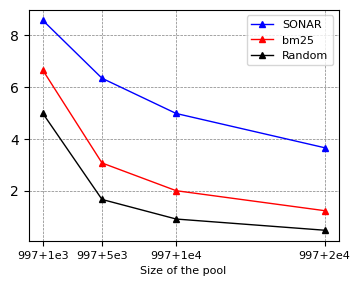

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(
    figsize=(4, 3)
    #figsize=(3, 2)
)
K = [1997, 5997, 10997, 20997]
labels = ["997+1e3", "997+5e3", "997+1e4", "997+2e4"]
plt.xticks(
    K,
    labels,
    fontsize=8
)

sonar = [8.58, 6.34, 4.98, 3.66]
bm25 = [6.66, 3.07, 2.00, 1.23]
aleatoire = [10*997/k for k in K]

plt.plot(
    K[:len(sonar)],
    sonar,
    linestyle="solid",
    linewidth=1.0,
    marker="^",
    markersize=5,
    label="SONAR",
    color = "blue"
)
plt.plot(
    K[:len(bm25)],
    bm25,
    linestyle="solid",
    linewidth=1.0,
    marker="^",
    markersize=5,
    label="bm25",
    color="red"
)
plt.plot(
    K[:len(aleatoire)],
    aleatoire,
    linestyle="solid",
    linewidth=1.0,
    marker="^",
    markersize=5,
    label="Random",
    color="black"
)

plt.xlabel("Size of the pool", fontsize=8)
#plt.ylabel(f"Number of chosen elements", fontsize=8)
plt.grid(color="grey", linestyle="--", linewidth=0.5)
#plt.title("Average number of elements belonging to `dev`set in 10-shot.", fontsize=10)
plt.legend(fontsize=8)
#plt.savefig("top.pdf", format="pdf", bbox_inches="tight")
plt.show()